# <strong>알고리즘 트레이딩 모델링

<br>
## <strong>통계적 차익거래</strong> statistical Arbitrage 
1. <strong>Pairs Trading</strong>(에드워드 소프) : 상관관계가 높은 주식간의 Spread를 통계분석/Hedge전략으로 매수/매도
  1. ex) 간격이 급격히 벌어지면 가격이 낮은 종목을 사고, 일정 간격이상 가까워 지면 판다
<p><img src="http://3.bp.blogspot.com/-D6OE7p20dj8/TrIKVzj9ruI/AAAAAAAAAAU/yNivE6bEBtM/s1600/graph.jpg" align="left" width="500"></p><br>

http://thelazytrader.com/articles/learn-to-trade/how-to-make-money-trend-following/
2. <strong>Trend Following</strong> (제임스 해리스 사이먼스) : <strong>Renaissance Tech</strong>를 운영하며 수많은 과거 데이터를 수집/분석 후 <strong>반복된 공식</strong>에 따라 운영
   1. 직원 대부분을 수학자, 물리학자, 천문학자, 컴퓨터과학자 등으로 구성하여 오직 수학적 분석에 따른 알고리즘을 개발한다

<div><img src="http://thelazytrader.com/wp-content/uploads/2013/05/bullish-cyclicity-copy.jpg" align="left" width="400"></div>
<div><img src="http://thelazytrader.com/wp-content/uploads/2013/05/bearish-cyclicity-copy1.jpg" align="left" width="450"></div>

3. <strong>Citadel 해지펀드</strong> (케네스 그리핀) : 경제학과 출신으로 수학과, 컴퓨터 IT기술을 활용하여 모델개발/검증/거래를 자동화

<img src="http://www.tradingandinvestmentnews.co.uk/wp-content/uploads/2016/05/citadel.jpg" align="left" width="200">

<Br>
## <strong> 1 알고리즘 트레이딩 모델
1. 종류 : 평균회귀, 일간 모멘텀, 추세추종, 인덱스 펀드 재분배
2. 분류 : Alpha 모델(시장 평균을 상위), Beta모델 (시장 평균을 약간 상위)
3. 접근법
    1. Theory-Driven (Top-down방식) : 모델을 가정 후 검증으로 모델을 완성
    2. Data-Driven (Bottom-up방식) : 데이터를 분석하며 모델을 완성 ex)인간게놈모델

<br>
## <strong>2 평균회귀모델
<strong>모델의 정상성(Stationarity)</strong>이라는 시계열 특성을 바탕으로, <strong>주가의 평균회귀 가설</strong>을 통해 모델을 완성

<strong>하지만 대부분의 주가는 독립적이고, 대부분 Random Walk를 보인다

<strong>평균회귀 모델 테스트 : ADF (Augmented Dickey Fuller) 테스트, 허스트 지수 (Hurst Exponent)

<img src="http://cfile21.uf.tistory.com/image/227BFF3C53D0C6E81BEA85" align="left">

### <strong>01 ADF 테스트
평균보다 현재가가 낮으면, 상승 방향성을 예측가능 (일반적 방향추세) 

<strong>ADF테스트</strong>는 <strong>시계열 데이터가 랜덤위크를 따른다</strong>는 가설은 세우고 이를 검증한다

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import get_data_yahoo
stock = get_data_yahoo('005930.KS', '2017-01-01')

In [2]:
# inAlgError ("SVD did not converge") : Nan, int 가 포함시 발생한다
from statsmodels.tsa.stattools import adfuller
X = pd.Series(stock.Close[1:]) 
result = adfuller(X.values)
print('ADF검정통계량 (ADF Statistic) : {:.4f} \np-value: {:.4f}'.format(result[0],result[1]))
print('가설검증을 위한 기각값 (Critical Values) :')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# 모델의 해석
# \gamma = 0 가설 (랜덤위크 분포를 따은다)은, 
# '검정통계값'이 1%, 5%, 10% 기각 값 어느하나 보다 더 작아야 참이된다
#  아래 분석결과 ADF '검정통계값'은 1,5,10% 기각값 보다 크므로, 
# '평균회귀 모델'을 적용할 수 없다는 결론에 도달한다

ADF검정통계량 (ADF Statistic) : -0.7272 
p-value: 0.8396
가설검증을 위한 기각값 (Critical Values) :
	1%: -3.463
	5%: -2.876
	10%: -2.574


### <strong>02 허스트 지수 (Hurst Exponent)
평균과 표준편차가 일정한 <strong>정상과정</strong>과 , <strong>브라운 운동(GBM : 표류하는 랜덤워크)</strong>을 비교하여

주가를 시간에 따른 가격변화의 확산으로, 얼마나 빠르게 퍼져나가는지를 수학적으로 측정할 수 있다

허스트 지수의 핵심은 위의 분산(Variance)을 확산속도로 치환하여, GBM의 확산 속도와 비교하면 

랜덤워크(Random Walk)/ 정상과정 여부를 판단 가능하다는 점에서 출발한다

GBM 에 해당하는 경우 : $\gamma = 1 일 때 $ <strong>H = 0.5</strong> 를 갖는다

<strong>주가의 확산속도</strong> : $ Var(\gamma) = [|log(t+\gamma) - log(\gamma)|^2]$

In [3]:
def get_hurst_exponent(df,lags_count=100):
    lags = range(2, lags_count)
    ts = np.log(df)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    result = poly[0]*2.0
    return result

In [4]:
hurst_sumsung = get_hurst_exponent(stock.Close)
hurst_sumsung

0.12883535932234233

In [5]:
# 기아차 주식 가격
stock_kia = get_data_yahoo('000270.KS', '2017-01-01')
hurst_kia = get_hurst_exponent(stock_kia.Close)
hurst_kia

0.31324458907191238

In [6]:
# 분석
# GBM 에 해당하는 0.5 와 다른 결과값을 나타내는 것으로써
# 주가는 뚜렷한 평균회귀 및 추세성향은 보이지 않는다

### <strong>03 평균회귀 Half-Life
위의 2가지 평균회귀 테스트에 실패한 모델인 경우에도 적용 가능하다

<strong>Half-Life</strong> : 값이 평균으로 회귀하는데 걸리는 시간으로, 

평균회귀 성향이 있는 랜덤워크과정을 <strong>오른스타인-우렌벡 과정(Ornstein-Uhlenbeck Process)</strong>라고 한다

$ dx_t = \lambda(\mu - x_t)dt + \sigma dW_t$

<strong>측정값이 크면</strong> : 장기간 지속경향이 있다, <strong>측정값이 작으면</strong> : 주가의 변동이 잦다

In [7]:
def get_half_life(df):
    price = pd.Series(df)  
    lagged_price = price.shift(1).fillna(method="bfill")  
    delta = price - lagged_price  
    beta = np.polyfit(lagged_price, delta, 1)[0] 
    half_life = (-1*np.log(2)/beta) 
    return half_life

In [8]:
get_half_life(stock.Close)

155.90175999935599

In [9]:
get_half_life(stock_kia.Close)

29.777473711034595

In [10]:
# 삼성전자는 상당히 벗어나서,평균으로 회귀할 가능성이 낮다
# 기아차는 상대적으로 평균으로 회귀한다

### <strong>04 평균회귀 모델의 구현
ADF테스트, 허스트지수, Half-life를 모두 통과한 모델의 경우, 평균회귀 모델을 구현이 가능하다

기본개념 : 평균보다 주가가 낮으면 매입/ 평균보다 높으면 매도를 해서 수익을 낸다
1. <strong>평균</strong> : 과거 특정기간의 주가, 이동평균을 이용(10, 30일) 중 어느것을 기준으로 할지 결정해야 한다
1. <strong>매도/매수</strong> : 기준이 너무 낮으면 이익이 적고, 너무 높으면 매도/매수시점을 놓칠 수 있다
1. <strong>데이터</strong> : 종가, 시가 등 어느것을 사용할 지 결정해야 한다

<img src="https://investorplace.com/wp-content/uploads/2012/08/08-02-12-spx.jpg" align='left' width='350'>

In [11]:
# 모델의 설정
# 1. 평균 : 10일 이동평균
# 2. 데이터 : 종가
# 3. 매도기준 : |주가-이동평균| > 표준편차 
# 4. 매수기준 : |주가-이동평균| < 표준편차 
# 5. 표준편차의 범위 : 정규분포상 표준편차 이내일 확률은 68%로 빈번한 매매가 이루어진다
#                   표준편차 3배의 범위는 0.3% 확률이 되어 트레이딩 횟수가 매우 적어진다

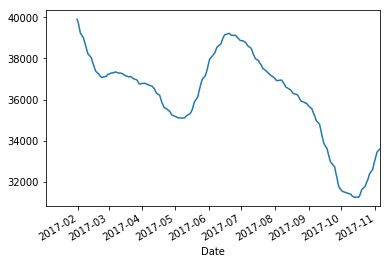

In [12]:
%matplotlib inline
# DataFrame.rolling(window=20,center=False).mean() : 이동평균선 구하기
stock_kia.rolling(window=20).mean().Close.plot(kind='line')

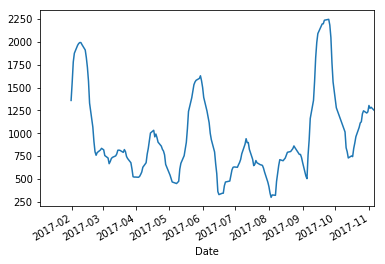

In [13]:
# 표준편차의 변화
stock_kia.rolling(window=20).std().Close.plot(kind='line')

<br>
## <strong>3 머신러닝 모델
데이터에서 시작하여 분석을 진행한다
### <strong>01 feature의 선택 (변수선택(Variable Selection), 속성선택(Attribute Selection))
출력변수와 <strong>연관성이 높은</strong>, 또는 <strong>이해하기 쉬운</strong> 입력변수를 선택
1. <strong>입력변수 예시</strong> : 주가, 거래량, index 지수, 외부데이터(환율/금리/뉴스), 기업데이터
1. <strong>Target 설정</strong> : 결과값을 명확히 결정후, 이에 적합한 문제정의 후 이를 중심으로 풀어가야 한다
    1. 머신러닝으로 <strong>종가를 예측 : 회귀모델</strong>을 생성
    2. 머신러닝으로 <strong>방향을 예측 : 분류모델</strong>을 생성

### <strong>02 분류모델
입력변수의 상관관계를 분석/예측, 결과는 이산값(one-hot-encoding)을 출력 ex)스팹분류
#### <strong>1) 로지스틱 회귀모델
1. 선형회귀에서 파생된 <strong>분류모델</strong>로써, 이산변수의 상관모델
1. <strong>X는 - 음수/ 양수</strong> 모두 사용 가능
1. <strong>Y는 - 0, 1</strong> 의 이분형결과(binary outcome)를 갖는다
1. 로지스틱 함수에서는 <strong>기울기를 결정하는 파라미터의 값</strong>을 찾는 것이 중요하다
1. cf) 결과값이 0.5 이상이면 True일 확률이 50% 이상이 된다

<img src = "http://img.my.csdn.net/uploads/201207/04/1341403634_5914.jpg" align='left' width='600'>

#### <strong>2) Decision Tree, Random Forest
Decision Tree는 입력변수의 특성을 Tree 구조에 Mapping하여 분류를 한다

1. 모양이 나무와 비슷하여, <strong>'분류와 회귀 트리(CART : Classification and Regression Tree)'</strong>라고도 한다
2. <strong>Random Forest</strong>는 여러 의사결정 Tree를 앙상블하여 예측력을 높인 모델을 생성한다

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/CART_tree_titanic_survivors_KOR.png/350px-CART_tree_titanic_survivors_KOR.png" align='left'>

#### <strong>3) SVM
Support Vector Machine 은 딥러닝이 활성화 되기 전, 가장 높은 인기를 갖는 알고리즘이었다
1. <strong>기본아이디어</strong> : 데이터의 분류 경계선중 <strong>W가 가장 큰(거리가 먼)경계선</strong>을 찾고, <strong>경계선 근처에 분포한 Data</strong>를 Support Vector라 한다
2. <strong>커널트릭</strong> : 선형분류가 어려운 경우, 원본 데이터를 <strong>다른 차원의 공간인 Feacture Space로 변환</strong>하여 최적의 
경계선을 찾는다

<img src="http://www.cristiandima.com/static/images/svm-kernel.png" align="left" width="500">

<br>
## <strong>4 머신러닝 모델 구현
Scikit learn 라이브러리를 활용하여, 전날의 종가/ 거래량 데이터로 주가 방향을 예측한다

### <strong>01 Data_Set
time_lags=5 : 5일 전 데이터까지 활용하여 예측

In [14]:
def make_dataset(df, time_lags=5):
    # DataFrame.shift(delta) : 시계열 데이터의 전 일자만큼 데이터를 수집한다
    # DataFrame.pct_change() : 데이터 변화를 %로 계산한다 
    df_lag = pd.DataFrame(index=df.index)
    df_lag["Close"] = df["Close"]
    df_lag["Volume"] = df["Volume"]

    df_lag["Close_Lag%s" % str(time_lags)] = df["Close"].shift(time_lags)
    df_lag["Close_Lag%s_Change" % str(time_lags)] = df_lag["Close_Lag%s" % str(time_lags)].pct_change()*100.0

    df_lag["Volume_Lag%s" % str(time_lags)] = df["Volume"].shift(time_lags)
    df_lag["Volume_Lag%s_Change" % str(time_lags)] = df_lag["Volume_Lag%s" % str(time_lags)].pct_change()*100.0

    df_lag["Close_Direction"] = np.sign(df_lag["Close_Lag%s_Change" % str(time_lags)])
    df_lag["Volume_Direction"] = np.sign(df_lag["Volume_Lag%s_Change" % str(time_lags)])

    return df_lag.dropna(how='any')

In [15]:
make_dataset(stock)[::30]
# ._Lag/ ._Lag_Change : delta 일자 까지의 데이터 변화/ 변화율 (%)
# ._Direction         : +1. 상승, -1. 하락 의미

,Close,Volume,Close_Lag5,Close_Lag5_Change,Volume_Lag5,Volume_Lag5_Change,Close_Direction,Volume_Direction
Date,,,,,,,,
2017-01-10,1862000.0,181996,1824000.0,1.052632,147153.0,58.208618,1.0,1.0
2017-02-23,1959000.0,204346,1901000.0,0.795334,204527.0,-27.940570,1.0,-1.0
2017-04-07,2080000.0,200420,2060000.0,-1.858028,210006.0,27.990005,-1.0,1.0
2017-05-25,2284000.0,260896,2297000.0,-0.863185,223207.0,50.318879,-1.0,1.0
2017-07-07,2393000.0,162638,2377000.0,-0.834376,237551.0,42.990170,-1.0,1.0
2017-08-21,2342000.0,102069,2231000.0,-2.788671,508146.0,10.533082,-1.0,1.0
2017-10-10,2640000.0,410396,2681000.0,0.000000,0.0,-100.000000,0.0,-1.0


### <strong>02 Data_Set 나누기
Test_set과 Train_set으로 데이터를 나눈다

시계열 데이터의 데이터 분할을 위해 별도의 사용자 함수를 생성한다

In [16]:
# percent 에 따른 날짜를 자동으로 계산하여 결과를 출력한다
def get_date_by_percent(start_date, end_date, percent):
    days = (end_date - start_date).days
    target_days = np.trunc(days * percent)
    target_date = start_date + datetime.timedelta(days=target_days)
    return target_date      # print (days, target_days,target_date)

# 입력변수와 출력변수 값을 일정 비율로 나눈다
def split_dataset(df, input_column_array, output_column, spllit_ratio):
    split_date = get_date_by_percent(df.index[0],df.index[df.shape[0]-1],spllit_ratio)

    input_data = df[input_column_array]
    output_data = df[output_column]

    X_train = input_data[input_data.index < split_date]
    X_test = input_data[input_data.index >= split_date]
    Y_train = output_data[output_data.index < split_date]
    Y_test = output_data[output_data.index >= split_date]

    return X_train,X_test,Y_train,Y_test

### <strong>03 주가방향 예측변수 작성
sci-kit learn 모듈을 활용

In [17]:
# 로지스틱 예측 모듈
def do_logistic_regression(x_train, y_train):
    from sklearn.linear_model import LogisticRegression
    classifier = LogisticRegression()
    classifier.fit(x_train, y_train) # .fit : 훈련모듈에 데이터를 적용한다
    return classifier

# 랜덤포레스트 예측모듈
def do_random_forest(x_train, y_train):
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier()
    classifier.fit(x_train, y_train)
    return classifier

# SVM 예측모듈
def do_svm(x_train, y_train):
    from sklearn.svm import LinearSVC, SVC
    classifier = SVC() # SVC(gamma=0.001, C=100) : 세부설정을 할 경우
    classifier.fit(x_train, y_train)
    return classifier

### <strong>04 주가방향 예측변수 실행 및 평가
주가방향 예측력 평가

In [18]:
def test_predictor(classifier, x_test, y_test):
    pred = classifier.predict(x_test)
    hit_count = 0
    total_count = len(y_test)
    for index in range(total_count):
        if (pred[index]) == (y_test[index]):
            hit_count = hit_count + 1    
    hit_ratio = hit_count/total_count
    score = classifier.score(x_test, y_test)
    return hit_ratio, score

In [19]:
import datetime
avg_hit_ratio = 0    
for time_lags in range(1,6):
    print ("- Time Lags=%s" % (time_lags))
#     for company in ['samsung','hanmi']:
    df_company = stock_kia
    df_dataset = make_dataset(df_company, time_lags)
    X_train, X_test, Y_train, Y_test = split_dataset(
        df_dataset,["Close_Lag%s"%(time_lags),
                    "Volume_Lag%s"%(time_lags)],"Close_Direction",0.75)
    lr_classifier = do_logistic_regression(X_train, Y_train)  # 로지스틱 분석
#     lr_hit_ratio, lr_score = test_predictor(lr_classifier, X_test, Y_test)
    rf_classifier = do_random_forest(X_train, Y_train)        # 랜덤포레스트 분석
#     rf_hit_ratio, rf_score = test_predictor(rf_classifier, X_test, Y_test)
    svm_classifier = do_svm(X_train, Y_train)                 # SVM 분석
#     svm_hit_ratio, svm_score = test_predictor(rf_classifier, X_test, Y_test)
#     print ("{} : Hit Ratio - Logistic Regreesion={:.2f},\nRandomForest={:.2f},\nSVM={:.2f}".
#            format(company, lr_hit_ratio, rf_hit_ratio, svm_hit_ratio))

- Time Lags=1
- Time Lags=2
- Time Lags=3
- Time Lags=4
- Time Lags=5


In [20]:
lr_classifier.predict(X_test)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,
        1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1.,
       -1., -1.,  1., -1., -1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.,
       -1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.])

In [21]:
Y_test.values

array([-1., -1.,  1.,  1., -1., -1., -1.,  1.,  1., -1.,  1., -1.,  1.,
       -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1.,
       -1., -1.,  0.,  1., -1.,  1.,  0.,  1.,  1., -1., -1.,  1., -1.,
        1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.])

<br>
## <strong>5 시간가치 감소효과
1. 평균회귀, 머신러닝 등을 활용하여 알파 모델을 생성생성한다
2. 알파모델을 테스트 튜닝 뒤 실전에 적용하면 ,시간에 따라 점차 수익성이 낮아진다
3. 이러한 Life Cycle을 '시간가치 감소효과'라고 한다
    1. 컴퓨터 트레이딩의 범람으로, 다른 모델에 의해 나의 모델이 희석된다
    2. 주가가 '표류하는 랜덤워크'를 따르므로, 시가니 지날수록 변동성이 커진다